In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import DataFrameNaFunctions as DFna
from pyspark.sql.functions import udf, col, when
import matplotlib.pyplot as plt
from pyspark import SQLContext
from pyspark.sql.functions import *
import pyspark as ps
from pyspark.sql.types import *
import os, sys, requests, json
import numpy as np
import math
import time
import pandas as pd
from surprise import SVD, NMF, model_selection, accuracy
import os
os.environ["PYSPARK_PYTHON"]="/usr/local/bin/python3"
# import String indexer to convert string values to numeric values
from pyspark.ml.feature import StringIndexer,IndexToString
#import ALS recommender function from pyspark ml library
from pyspark.ml.recommendation import ALS
#importing Regression Evaluator to measure RMSE
from pyspark.ml.evaluation import RegressionEvaluator


In [2]:
temp_df = pd.read_csv('File_Amazon.tsv', sep='\t')
temp_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4,2,3,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3,5,5,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4,1,22,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5,2,2,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4,0,2,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


In [3]:
temp_df = temp_df[['customer_id','product_title','star_rating']]
temp_df

,customer_id,product_title,star_rating
0,12076615,Sisterhood of the Traveling Pants (Book 1),4
1,12703090,The Bad Girl's Guide to Getting What You Want,3
2,12257412,"Eisenhorn (A Warhammer 40,000 Omnibus)",4
3,50732546,Colby Conspiracy (Colby Agency),5
4,51964897,The Psychology of Proof: Deductive Reasoning i...,4
...,...,...,...
99985,17077611,Theoretical Foundations of Corporate Finance.,4
99986,52433809,Data Structures and Program Design In C (2nd E...,4
99987,12579502,Sang Spell,1
99988,21369002,"Reef Fish Identification: Florida, Caribbean, ...",5


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import math
import csv
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
%matplotlib inline


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

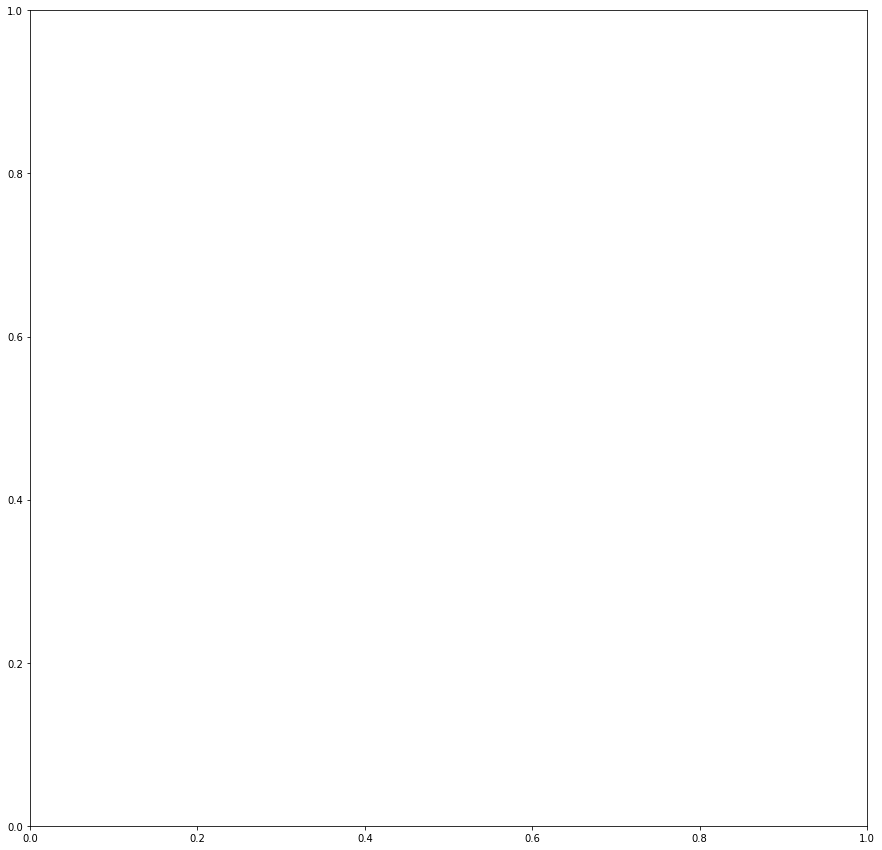

In [5]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(temp_df, vmax=.7, square=True);
ax.set_title('Heatmap showing the Correlation between variables')

In [ ]:
#temp_df = temp_df[temp_df.product_id.apply(lambda x: x.isnumeric())]
#temp_df 

In [6]:
mySchema = StructType([ StructField("customer_id", IntegerType(), True)\
                       ,StructField("product_title", StringType(), True)\
                       ,StructField("star_rating", IntegerType(), True)])

In [7]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("building recommender") \
            .getOrCreate() # create a spark session
            
sc = spark.sparkContext # create a spark context

In [8]:
sqlContext = SQLContext(sc)

In [9]:
amazon_df = spark.createDataFrame(temp_df,schema=mySchema)

In [10]:
print("line count: {}".format(amazon_df.count()))

line count: 99990


In [11]:
amazon_df.show(5)

+-----------+--------------------+-----------+
|customer_id|       product_title|star_rating|
+-----------+--------------------+-----------+
|   12076615|Sisterhood of the...|          4|
|   12703090|The Bad Girl's Gu...|          3|
|   12257412|Eisenhorn (A Warh...|          4|
|   50732546|Colby Conspiracy ...|          5|
|   51964897|The Psychology of...|          4|
+-----------+--------------------+-----------+
only showing top 5 rows



In [12]:
print('dataset data size: ', amazon_df.count(),' rows') 

dataset data size:  99990  rows


In [13]:
null_prod = amazon_df.where(col("customer_id").isNull())
null_prod.show(5)

+-----------+-------------+-----------+
|customer_id|product_title|star_rating|
+-----------+-------------+-----------+
+-----------+-------------+-----------+



In [14]:
null_cust = amazon_df.where(col("product_title").isNull())
null_cust.show(5)

+-----------+-------------+-----------+
|customer_id|product_title|star_rating|
+-----------+-------------+-----------+
+-----------+-------------+-----------+



In [15]:
null_cust = amazon_df.where(col("star_rating").isNull())
null_cust.show(5)

+-----------+-------------+-----------+
|customer_id|product_title|star_rating|
+-----------+-------------+-----------+
+-----------+-------------+-----------+



In [16]:
#The users who have have rated the least number of books
amazon_df.groupBy('customer_id').count().orderBy('count',ascending=False).show(10,False)

+-----------+-----+
|customer_id|count|
+-----------+-----+
|50122160   |712  |
|12598621   |371  |
|50732546   |355  |
|39569598   |252  |
|50776149   |231  |
|35985708   |201  |
|49273674   |171  |
|14720400   |155  |
|24821538   |149  |
|38491967   |138  |
+-----------+-----+
only showing top 10 rows



In [17]:
#The users who have have rated the least number of books
amazon_df.groupBy('customer_id').count().orderBy('count',ascending=True).show(10,False)

+-----------+-----+
|customer_id|count|
+-----------+-----+
|38922240   |1    |
|23469878   |1    |
|12072379   |1    |
|34946095   |1    |
|23475578   |1    |
|36554584   |1    |
|38722834   |1    |
|52165591   |1    |
|13492514   |1    |
|22735091   |1    |
+-----------+-----+
only showing top 10 rows



In [18]:
#creating string indexer to convert the book title column values into numerical values
stringIndexer = StringIndexer(inputCol="product_title", outputCol="product_title_new")

In [19]:
model = stringIndexer.fit(amazon_df)

In [20]:
#creating new dataframe with transformed values
indexed = model.transform(amazon_df)

In [21]:
#validate the numerical title values
indexed.show(10)

+-----------+--------------------+-----------+-----------------+
|customer_id|       product_title|star_rating|product_title_new|
+-----------+--------------------+-----------+-----------------+
|   12076615|Sisterhood of the...|          4|            320.0|
|   12703090|The Bad Girl's Gu...|          3|          12482.0|
|   12257412|Eisenhorn (A Warh...|          4|           5662.0|
|   50732546|Colby Conspiracy ...|          5|          28123.0|
|   51964897|The Psychology of...|          4|          33816.0|
|   31048862|The Catcher in th...|          4|             81.0|
|   53000124|Bait and Switch: ...|          4|             35.0|
|   29732693|Opening Combinati...|          4|          53576.0|
|   48541186|A Little History ...|          5|          25683.0|
|   15280864|Hour Game (King &...|          4|            170.0|
+-----------+--------------------+-----------+-----------------+
only showing top 10 rows



In [22]:
#number of times each numerical book title has been rated 
indexed.groupBy('product_title_new').count().orderBy('count',ascending=False).show(10,False)

+-----------------+-----+
|product_title_new|count|
+-----------------+-----+
|0.0              |630  |
|1.0              |531  |
|2.0              |376  |
|3.0              |366  |
|4.0              |224  |
|5.0              |186  |
|6.0              |146  |
|7.0              |136  |
|8.0              |134  |
|9.0              |107  |
+-----------------+-----+
only showing top 10 rows



In [23]:
#split the data into training and test datatset
train,test=indexed.randomSplit([0.75,0.25])

In [24]:
#count number of records in train set
train.count()

75049

In [25]:
#count number of records in test set
test.count()

24941

In [26]:
#Training the recommender model using train datatset
rec=ALS(maxIter=10,regParam=0.01,userCol='customer_id',itemCol='product_title_new',ratingCol='star_rating',nonnegative=True,coldStartStrategy="drop")

In [27]:
rec

ALS_941a1eecde08

In [28]:
#fit the model on train set
rec_model=rec.fit(train)

In [29]:
#making predictions on test set 
predicted_ratings=rec_model.transform(test)

In [30]:
#columns in predicted ratings dataframe
predicted_ratings.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- product_title_new: double (nullable = false)
 |-- prediction: float (nullable = false)



In [31]:
#predicted vs actual ratings for test set 
predicted_ratings.show(10)

+-----------+--------------------+-----------+-----------------+----------+
|customer_id|       product_title|star_rating|product_title_new|prediction|
+-----------+--------------------+-----------+-----------------+----------+
|   20379359|Inside the Mind o...|          2|            148.0| 6.6003437|
|   36642996|Inside the Mind o...|          5|            148.0|  4.549569|
|   17782992|Inside the Mind o...|          2|            148.0| 1.0612826|
|   53090372|Urban Shaman (The...|          5|            463.0| 2.0490804|
|   51071403|Urban Shaman (The...|          5|            463.0| 3.4183264|
|   17733929|Urban Shaman (The...|          3|            463.0| 2.1701374|
|   49918786|The Angel Experim...|          4|            471.0| 3.7440085|
|   12230962|       American Gods|          5|            496.0|  3.289894|
|   53096155|                 Dog|          3|            833.0|    1.9719|
|   40865923|The Story of the ...|          5|           1238.0| 3.3464904|
+-----------

In [32]:
Pred_Ratings=predicted_ratings.withColumn('err',(predicted_ratings['prediction'] - predicted_ratings['star_rating']))

In [33]:
Pred_Ratings.show(10)

+-----------+--------------------+-----------+-----------------+----------+-----------+
|customer_id|       product_title|star_rating|product_title_new|prediction|        err|
+-----------+--------------------+-----------+-----------------+----------+-----------+
|   20379359|Inside the Mind o...|          2|            148.0| 6.6003437|  4.6003437|
|   36642996|Inside the Mind o...|          5|            148.0|  4.549569|-0.45043087|
|   17782992|Inside the Mind o...|          2|            148.0| 1.0612826|-0.93871737|
|   53090372|Urban Shaman (The...|          5|            463.0| 2.0490804| -2.9509196|
|   51071403|Urban Shaman (The...|          5|            463.0| 3.4183264| -1.5816736|
|   17733929|Urban Shaman (The...|          3|            463.0| 2.1701374| -0.8298626|
|   49918786|The Angel Experim...|          4|            471.0| 3.7440085|-0.25599146|
|   12230962|       American Gods|          5|            496.0|  3.289894| -1.7101059|
|   53096155|                 Do

In [34]:
amazon_df.groupBy('star_rating').count().orderBy('star_rating',ascending=True).show()

+-----------+-----+
|star_rating|count|
+-----------+-----+
|          1| 7357|
|          2| 4749|
|          3| 8333|
|          4|19978|
|          5|59573|
+-----------+-----+



In [35]:
Pred_Ratings.groupBy('star_rating').agg({'err':'mean'}).orderBy('star_rating',ascending=True).show()

+-----------+-------------------+
|star_rating|           avg(err)|
+-----------+-------------------+
|          1| 0.8114635746575257|
|          2| 0.1755152353780524|
|          3|-0.7190319649153004|
|          4|-1.4136076759634995|
|          5| -2.313555982923999|
+-----------+-------------------+



In [36]:
#create Regressor evaluator object for measuring accuracy
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='star_rating')

In [37]:
#apply the RE on predictions dataframe to calculate RMSE
rmse=evaluator.evaluate(predicted_ratings)

In [38]:
#print RMSE error
print(rmse)

2.827761137983841


In [39]:
#create dataset of all distinct books 
unique_books=indexed.select('product_title_new').distinct()

In [40]:
#number of unique books
unique_books.count()

62329

In [41]:
a = unique_books.alias('a')

In [42]:
user_id=50122160

In [43]:
#creating another dataframe which contains already read book by active user 
read_books=indexed.filter(indexed['customer_id'] == user_id).select('product_title_new').distinct()

In [44]:
#number of book already rated 
read_books.count()

636

In [45]:
#assigning alias name 'b' to read books
b=read_books.alias('b')

In [46]:
#joining both tables on left join 
total_books = a.join(b, a.product_title_new == b.product_title_new,how='left')

In [47]:
total_books.show(10,False)

+-----------------+-----------------+
|product_title_new|product_title_new|
+-----------------+-----------------+
|299.0            |null             |
|305.0            |null             |
|496.0            |null             |
|558.0            |null             |
|596.0            |null             |
|692.0            |null             |
|769.0            |null             |
|934.0            |null             |
|1051.0           |null             |
|1761.0           |null             |
+-----------------+-----------------+
only showing top 10 rows



In [48]:
#selecting books which active user is yet to rate or watch
remaining_books=total_books.where(col("b.product_title_new").isNull()).select(a.product_title_new).distinct()

In [49]:
remaining_books.count()

61693

In [50]:
#adding new column of user_Id of active useer to remaining books  
remaining_books=remaining_books.withColumn("customer_id",lit(int(user_id)))

In [51]:
remaining_books.show(10,False)

+-----------------+-----------+
|product_title_new|customer_id|
+-----------------+-----------+
|299.0            |50122160   |
|305.0            |50122160   |
|496.0            |50122160   |
|558.0            |50122160   |
|596.0            |50122160   |
|692.0            |50122160   |
|769.0            |50122160   |
|934.0            |50122160   |
|1051.0           |50122160   |
|1761.0           |50122160   |
+-----------------+-----------+
only showing top 10 rows



In [52]:
#making recommendations using ALS recommender model and selecting only top 'n' books
recommendations=rec_model.transform(remaining_books).orderBy('prediction',ascending=False)

In [53]:
recommendations.show(5,False)

+-----------------+-----------+----------+
|product_title_new|customer_id|prediction|
+-----------------+-----------+----------+
|45123.0          |50122160   |8.16131   |
|4832.0           |50122160   |8.056374  |
|4334.0           |50122160   |8.003     |
|10716.0          |50122160   |7.9968615 |
|3178.0           |50122160   |7.967109  |
+-----------------+-----------+----------+
only showing top 5 rows



In [54]:
product_title = IndexToString(inputCol="product_title_new", outputCol="product_title",labels=model.labels)

final_recommendations=product_title.transform(recommendations)

In [55]:
final_recommendations.show(10,False)

+-----------------+-----------+----------+---------------------------------------------------------------------------------------+
|product_title_new|customer_id|prediction|product_title                                                                          |
+-----------------+-----------+----------+---------------------------------------------------------------------------------------+
|45123.0          |50122160   |8.16131   |Statistical Analysis of Financial Data in S-Plus (Springer Texts in Statistics)        |
|4832.0           |50122160   |8.056374  |Essential ActionScript 2.0: Object-Oriented Development with ActionScript 2.0          |
|4334.0           |50122160   |8.003     |Work as a Heroic Journey:Using the Workplace to Evolve Your Character and Consciousness|
|10716.0          |50122160   |7.9968615 |The Letter of Marque (Vol. Book 12)  (Aubrey/Maturin Novels)                           |
|3178.0           |50122160   |7.967109  |The Bible for Men: Vol. 1 Women Friends a

In [56]:
#create function to recommend top 'n' books to any particular user
def topRecomendedBooks(customer_id,n):
    """
    This function returns the top 'n' books that user has not read yet but might like 
    
    """
    #assigning alias name 'a' to unique books 
    a = unique_books.alias('a')
    
    #creating another dataframe which contains already read books by active user 
    read_books=indexed.filter(indexed['customer_id'] == user_id).select('product_title_new')
    
    #assigning alias name 'b' to read books 
    b = read_books.alias('b')
    
    #joining both tables on left join 
    totalBooks = a.join(b, a['product_title_new'] == b['product_title_new'],how='left')

    
    #selecting bookd which active user is yet to rate or watch
    remaining_books=totalBooks.where(col("b.product_title_new").isNull()).select(a.product_title_new).distinct()
    
    
    #adding new column of user_Id of active useer to remaining books df 
    remaining_books=remaining_books.withColumn("customer_id",lit(int(user_id)))
    
    
    #making recommendations using ALS recommender model and selecting only top 'n' books
    recommendations=rec_model.transform(remaining_books).orderBy('prediction',ascending=False).limit(n)
    
    
    #adding columns of books titles in recommendations
    book_title = IndexToString(inputCol="product_title_new", outputCol="product_title",labels=model.labels)
    final_recommendations=book_title.transform(recommendations)
    
    #return the recommendations to active user
    return final_recommendations.show(n,False)

In [57]:
topRecomendedBooks(24821538,10) 

+-----------------+-----------+----------+---------------------------------------------------------------------------------------+
|product_title_new|customer_id|prediction|product_title                                                                          |
+-----------------+-----------+----------+---------------------------------------------------------------------------------------+
|45123.0          |50122160   |8.16131   |Statistical Analysis of Financial Data in S-Plus (Springer Texts in Statistics)        |
|4832.0           |50122160   |8.056374  |Essential ActionScript 2.0: Object-Oriented Development with ActionScript 2.0          |
|4334.0           |50122160   |8.003     |Work as a Heroic Journey:Using the Workplace to Evolve Your Character and Consciousness|
|10716.0          |50122160   |7.9968615 |The Letter of Marque (Vol. Book 12)  (Aubrey/Maturin Novels)                           |
|3178.0           |50122160   |7.967109  |The Bible for Men: Vol. 1 Women Friends a

In [ ]:
topRecomendedBooks(38491967,10)

In [ ]:
sc.stop()